In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import glob
import os

In [2]:
#Constants

BATCH_SIZE = 8
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df['path'] = '../input/cassava-leaf-disease-classification/train_images/' + df['image_id']
df.label.value_counts(normalize=True) * 100

3    61.494602
4    12.043744
2    11.151096
1    10.230406
0     5.080151
Name: label, dtype: float64

In [4]:
df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [5]:
# size_per_label = 1000
# g = df.groupby("label")
# df = g.apply(lambda x : x.sample(size_per_label, random_state = SEED)).reset_index(drop = True)
# df.label.value_counts()

In [6]:
X_train, X_valid = train_test_split(df, stratify = df.label, test_size = 0.1, random_state = SEED, shuffle=True)

train_ds = tf.data.Dataset.from_tensor_slices((X_train.path.values, X_train.label.values))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid.path.values, X_valid.label.values))

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
target_size_dim = 512

def process_data_train(image_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_crop(img, size=[target_size_dim, target_size_dim, 3])
    return img, label

def process_data_valid(image_path, label):
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [target_size_dim,target_size_dim])
    return img, label

In [8]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_data_train, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_data_valid, num_parallel_calls=AUTOTUNE)

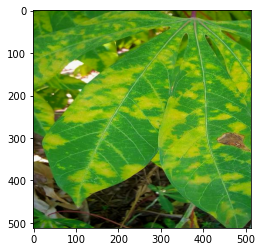

Image shape:  (512, 512, 3)
Label:  1


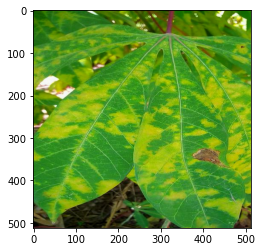

Image shape:  (512, 512, 3)
Label:  1


In [9]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype('uint8'))
    plt.show()
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype('uint8'))
    plt.show()
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [10]:
def configure_for_performance(ds, batch_size = 32):
    ds = ds.cache('/kaggle/dump.tfcache') 
    
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

batch_size = 8

train_ds_batch = configure_for_performance(train_ds, batch_size)
valid_ds_batch = valid_ds.batch(batch_size)

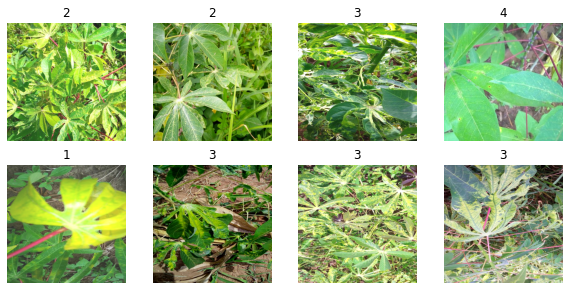

In [11]:
image_batch, label_batch = next(iter(train_ds_batch))

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i].numpy()
    plt.title(label)
    plt.axis("off")

In [12]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
    ]
)

In [13]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, drop_connect_rate=0.4)
base_model.trainable = False
    
inputs = tf.keras.layers.Input(shape = (target_size_dim, target_size_dim, 3))
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(5)(x)
outputs = Activation('softmax', dtype = 'float32', name = 'predictions')(x)

model = tf.keras.Model(inputs, outputs)
    
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

model.summary()

71688192/71686520 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_______________________________________________________

In [14]:
weight_path_save = 'best_model.hdf5'
last_weight_path = 'last_model.hdf5'

checkpoint = ModelCheckpoint(
                                weight_path_save, 
                                monitor= 'val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode= 'min', 
                                save_weights_only = False
                            )

checkpoint_last = ModelCheckpoint(
                                    last_weight_path, 
                                    monitor= 'val_loss', 
                                    verbose=1, 
                                    save_best_only=False, 
                                    mode= 'min', 
                                    save_weights_only = False
                                 )


early = EarlyStopping(
                        monitor = 'val_loss', 
                        mode = 'min', 
                        patience = 5
                     )

reduceLROnPlat = ReduceLROnPlateau(
                                    monitor='val_loss',
                                    factor=0.8,
                                    patience=2,
                                    verbose=1,
                                    mode='auto',
                                    epsilon=0.0001,
                                    cooldown=5,
                                    min_lr=0.00001
                                  )

callbacks_list = [checkpoint, checkpoint_last, early, reduceLROnPlat]

In [15]:
epochs = 4

history = model.fit(train_ds_batch, 
                    validation_data = valid_ds_batch,
                    epochs = epochs, 
                    callbacks = callbacks_list)

Epoch 1/4
2408/2408 [==============================] - ETA: 0s - loss: 0.8664 - sparse_categorical_accuracy: 0.6764
Epoch 00001: val_loss improved from inf to 0.64036, saving model to best_model.hdf5

Epoch 00001: saving model to last_model.hdf5
2408/2408 [==============================] - 377s 156ms/step - loss: 0.8664 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.7762
Epoch 2/4
2407/2408 [============================>.] - ETA: 0s - loss: 0.7282 - sparse_categorical_accuracy: 0.7350
Epoch 00002: val_loss improved from 0.64036 to 0.60201, saving model to best_model.hdf5

Epoch 00002: saving model to last_model.hdf5
2408/2408 [==============================] - 322s 134ms/step - loss: 0.7282 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.6020 - val_sparse_categorical_accuracy: 0.7855
Epoch 3/4
2407/2408 [============================>.] - ETA: 0s - loss: 0.6907 - sparse_categorical_accuracy: 0.7476
Epoch 00003: val_loss improved from 0.

In [16]:
def plot_hist(hist):
    plt.figure(figsize=(15,5))
    local_epochs = len(hist.history["sparse_categorical_accuracy"])
    plt.plot(np.arange(local_epochs, step=1), hist.history["sparse_categorical_accuracy"], '-o', label='Train Accuracy',color='#ff7f0e')
    plt.plot(np.arange(local_epochs, step=1), hist.history["val_sparse_categorical_accuracy"], '-o',label='Val Accuracy',color='#1f77b4')
    plt.xlabel('Epoch',size=14)
    plt.ylabel('Accuracy',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(local_epochs, step=1) ,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(local_epochs, step=1) ,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    plt.legend(loc=3)
    plt.ylabel('Loss',size=14)
    plt.title("Model Accuracy and loss")
    
    plt.savefig('loss.png')
    plt.show()

In [17]:
#plot_hist(history)

In [18]:
base_model.trainable = True

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)              

In [19]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 1e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

fine_tune_epochs = 6
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(train_ds_batch,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1] + 1,
                         validation_data = valid_ds_batch,
                         callbacks = callbacks_list)

Epoch 5/10
2408/2408 [==============================] - ETA: 0s - loss: 0.5552 - sparse_categorical_accuracy: 0.8071
Epoch 00005: val_loss improved from 0.59099 to 0.45305, saving model to best_model.hdf5

Epoch 00005: saving model to last_model.hdf5
2408/2408 [==============================] - 1833s 761ms/step - loss: 0.5552 - sparse_categorical_accuracy: 0.8071 - val_loss: 0.4531 - val_sparse_categorical_accuracy: 0.8514
Epoch 6/10
2408/2408 [==============================] - ETA: 0s - loss: 0.4616 - sparse_categorical_accuracy: 0.8432
Epoch 00006: val_loss improved from 0.45305 to 0.42080, saving model to best_model.hdf5

Epoch 00006: saving model to last_model.hdf5
2408/2408 [==============================] - 1834s 762ms/step - loss: 0.4616 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.4208 - val_sparse_categorical_accuracy: 0.8598
Epoch 7/10
2408/2408 [==============================] - ETA: 0s - loss: 0.4182 - sparse_categorical_accuracy: 0.8619
Epoch 00007: val_loss improve

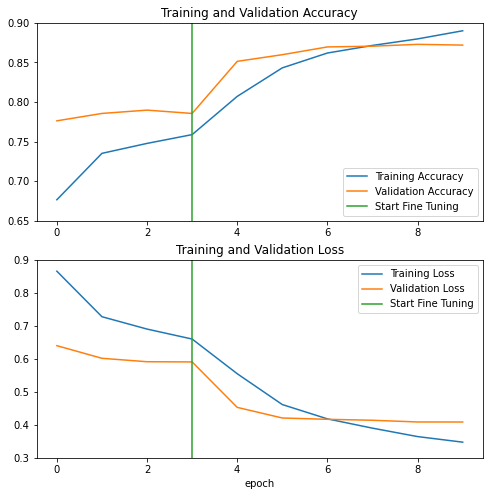

In [20]:
acc = history.history['sparse_categorical_accuracy'] + history_fine.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy'] + history_fine.history['val_sparse_categorical_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.65, 0.9])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.3, 0.9])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('loss.png')
plt.show()

In [21]:
model.load_weights(weight_path_save) ## load the best model or all your metrics would be on the last run not on the best one
pred_valid_y = model.predict(valid_ds_batch, workers=4, verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)

valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)

print(classification_report(valid_labels, pred_valid_y_labels ))

268/268 [==============================] - 34s 128ms/step
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       109
           1       0.84      0.74      0.79       219
           2       0.77      0.77      0.77       238
           3       0.95      0.96      0.95      1316
           4       0.70      0.70      0.70       258

    accuracy                           0.87      2140
   macro avg       0.78      0.77      0.77      2140
weighted avg       0.87      0.87      0.87      2140



In [22]:
import json
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


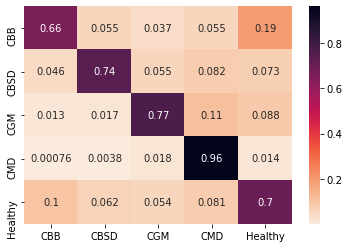

In [23]:
cm = confusion_matrix(valid_labels, pred_valid_y_labels )
cm = cm / cm.sum(axis = 1, keepdims = True)

desc = np.array(["CBB", "CBSD", "CGM", "CMD", "Healthy"])
cm = pd.DataFrame(data = cm, index = desc, columns = desc)

import seaborn as sns
sns.heatmap(cm, annot = True, cmap = "rocket_r")

In [25]:
import glob

test_images = glob.glob('../input/cassava-leaf-disease-classification/test_images/*.jpg')
df_test = pd.DataFrame(np.array(test_images), columns=['Path'])

test_ds = tf.data.Dataset.from_tensor_slices((df_test.Path.values))


def process_test(image_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_crop(img, size=[target_size_dim, target_size_dim, 3])
    return img
    
test_ds = test_ds.map(process_test, num_parallel_calls=AUTOTUNE).batch(batch_size*2)

preds = []
for i in range(5):
    
    pred_test = model.predict(test_ds, workers=16, verbose=1)
    preds.append(pred_test)

1/1 [==============================] - 0s 14ms/step


In [26]:
pred_y = np.mean(preds, axis=0)

pred_y_argmax = np.argmax(pred_y, axis=-1)

df_test['image_id'] = df_test.Path.str.split('/').str[-1]
df_test['label'] = pred_y_argmax
df_test= df_test[['image_id','label']]

df_test.to_csv('submission.csv', index=False)